# Chord Matching Demo with Colored Notation

This notebook demonstrates the `percent_chord_df_match` function from `music_df.harmony.matching`,
with **colored notation** to visually highlight which notes match their expected pitch classes.

- **Green** notes: match the expected chord PCs (chord tones)
- **Red** notes: don't match the expected chord PCs (non-chord tones)

In [13]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import io

import verovio
from IPython.display import SVG, display
import pandas as pd

from music_df.humdrum_export import df2hum
from music_df.harmony.chords import hex_str_to_pc_ints
from music_df.harmony.matching import percent_chord_df_match

In [15]:
MATCH_COLOR = "#00AA00"  # Green for matching chord tones
NO_MATCH_COLOR = "#DD0000"  # Red for non-chord tones


def show_chord_matching(result_df: pd.DataFrame, width: int = 1200, scale: int = 50) -> None:
    """Convert result DataFrame to colored notation and display it."""
    result_df = result_df.copy()
    
    # Calculate per-note match: does the note's pitch class match the chord PCs?
    def note_matches_chord(row):
        if row["type"] != "note" or pd.isna(row.get("chord_pcs")) or row["chord_pcs"] == "":
            return None
        chord_pcs = set(hex_str_to_pc_ints(row["chord_pcs"], return_set=True))
        return (row["pitch"] % 12) in chord_pcs
    
    result_df["is_chord_tone"] = result_df.apply(note_matches_chord, axis=1)
    result_df["color"] = result_df["is_chord_tone"].map({True: "match", False: "no_match"})
    result_df["has_chord"] = result_df["is_chord_tone"].notna()

    humdrum = df2hum(
        result_df,
        color_col="color",
        color_mask_col="has_chord",
        color_mapping={"match": MATCH_COLOR, "no_match": NO_MATCH_COLOR},
    )

    tk = verovio.toolkit()
    tk.setOptions({"pageWidth": width, "scale": scale, "adjustPageHeight": True})
    tk.loadData(humdrum)
    for page in range(1, tk.getPageCount() + 1):
        display(SVG(tk.renderToSVG(page)))

## Example 1: All Chord Tones (100% match)

C major (C-E-G) and G major (G-B-D) triads.
All notes match their expected PCs, so they appear **green**.

Chord match rate: 100%


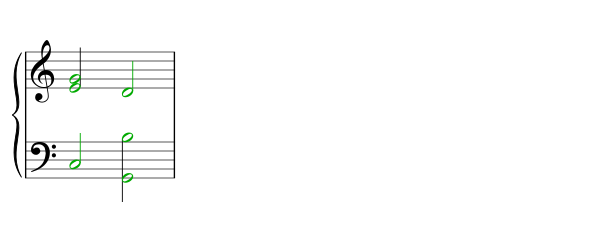

In [16]:
music_df1 = pd.read_csv(io.StringIO('''
type,pitch,onset,release,spelling
bar,,0.0,,
note,48,0.0,2.0,C
note,64,0.0,2.0,E
note,67,0.0,2.0,G
note,43,2.0,4.0,G
note,59,2.0,4.0,B
note,62,2.0,4.0,D
bar,,4.0,,
'''))

chord_df1 = pd.DataFrame({
    "onset": [0.0, 2.0],
    "release": [2.0, 4.0],
    "chord_pcs": ["047", "72B"],  # C major, G major
})

result1 = percent_chord_df_match(music_df1, chord_df1)
print(f"Chord match rate: {result1['microaverage']:.0%}")
show_chord_matching(result1["music_df"])

## Example 2: All Non-Chord Tones (0% match)

D-F-A notes against a C major chord, then C-E-G against a G major chord.
No notes match their expected PCs, so they appear **red**.

Chord match rate: 0%


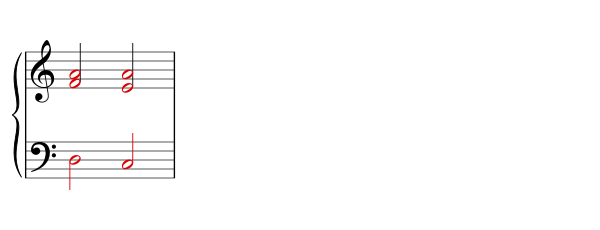

In [17]:
music_df2 = pd.read_csv(io.StringIO('''
type,pitch,onset,release,spelling
bar,,0.0,,
note,50,0.0,2.0,D
note,65,0.0,2.0,F
note,69,0.0,2.0,A
note,48,2.0,4.0,C
note,64,2.0,4.0,E
note,69,2.0,4.0,A
bar,,4.0,,
'''))

chord_df2 = pd.DataFrame({
    "onset": [0.0, 2.0],
    "release": [2.0, 4.0],
    "chord_pcs": ["047", "72B"],  # C major expected, then G major expected
})

result2 = percent_chord_df_match(music_df2, chord_df2)
print(f"Chord match rate: {result2['microaverage']:.0%}")
show_chord_matching(result2["music_df"])

## Example 3: Mixed (Partial match)

First chord has all chord tones (green),
second chord has all non-chord tones (red).

Chord match rate: 67%


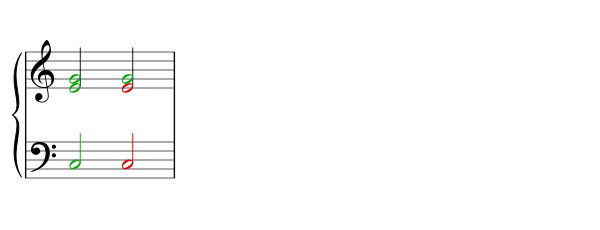

In [18]:
music_df3 = pd.read_csv(io.StringIO('''
type,pitch,onset,release,spelling
bar,,0.0,,
note,48,0.0,2.0,C
note,64,0.0,2.0,E
note,67,0.0,2.0,G
note,48,2.0,4.0,C
note,64,2.0,4.0,E
note,67,2.0,4.0,G
bar,,4.0,,
'''))

chord_df3 = pd.DataFrame({
    "onset": [0.0, 2.0],
    "release": [2.0, 4.0],
    "chord_pcs": ["047", "72B"],  # C major matches first, G major doesn't match second
})

result3 = percent_chord_df_match(music_df3, chord_df3)
print(f"Chord match rate: {result3['microaverage']:.0%}")
show_chord_matching(result3["music_df"])

## Example 4: Duration Weighting Demo

A C major chord with a passing tone:
- C-E-G (matching) held for 3 beats -> green
- D (non-matching passing tone) held for 1 beat -> red

With duration weighting: (3+3+3+0)/(3+3+3+1) = 90%
Without duration weighting: 3/4 = 75%

With duration weighting:    90%
Without duration weighting: 75%


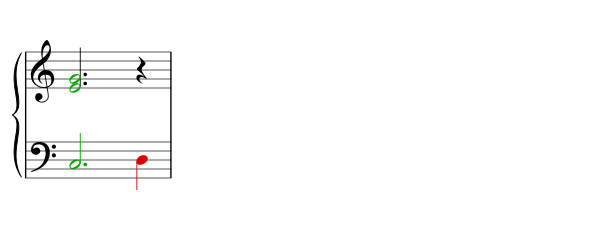

In [19]:
music_df4 = pd.read_csv(io.StringIO('''
type,pitch,onset,release,spelling
bar,,0.0,,
note,48,0.0,3.0,C
note,64,0.0,3.0,E
note,67,0.0,3.0,G
note,50,3.0,4.0,D
bar,,4.0,,
'''))

chord_df4 = pd.DataFrame({
    "onset": [0.0],
    "release": [4.0],
    "chord_pcs": ["047"],  # C major expected throughout
})

result4_weighted = percent_chord_df_match(music_df4, chord_df4, weight_by_duration=True)
result4_unweighted = percent_chord_df_match(music_df4, chord_df4, weight_by_duration=False)

print(f"With duration weighting:    {result4_weighted['microaverage']:.0%}")
print(f"Without duration weighting: {result4_unweighted['microaverage']:.0%}")
show_chord_matching(result4_weighted["music_df"])

## Real Music Examples

Now let's apply chord matching to real music from the test resources.

In [20]:
from music_df.read_csv import read_csv as mdf_read_csv

EXAMPLE_DIR = Path("../tests/resources/example_dfs")


def load_first_n_bars(notes_path: Path, chords_path: Path, n_bars: int = 4):
    """Load notes and chords, filter to first n bars."""
    notes_df = mdf_read_csv(str(notes_path)).reset_index()
    chords_df = pd.read_csv(chords_path)

    # Fix time signature values (some CSVs have floats instead of ints)
    ts_mask = notes_df["type"] == "time_signature"
    for idx in notes_df[ts_mask].index:
        other = notes_df.at[idx, "other"]
        if isinstance(other, dict):
            other["numerator"] = int(other["numerator"])
            other["denominator"] = int(other["denominator"])

    # Find bar boundaries
    bars = notes_df[notes_df["type"] == "bar"]["onset"].sort_values()
    if len(bars) > n_bars:
        cutoff = bars.iloc[n_bars]
    else:
        cutoff = notes_df["release"].max()

    # Filter to first n bars
    notes_filtered = notes_df[notes_df["onset"] < cutoff].copy()
    chords_filtered = chords_df[chords_df["onset"] < cutoff].copy()

    return notes_filtered, chords_filtered

Chord match rate: 92%


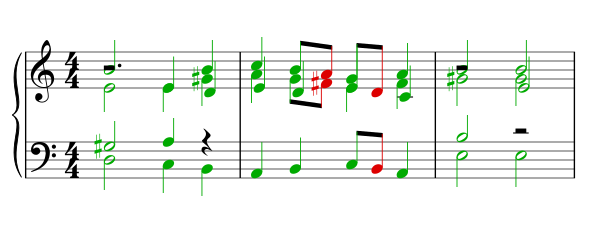

In [25]:
bach_notes, bach_chords = load_first_n_bars(
    EXAMPLE_DIR / "Bach,_Johann_Sebastian_Chorales_010_notes.csv",
    EXAMPLE_DIR / "Bach,_Johann_Sebastian_Chorales_010_chords.csv",
    n_bars=4,
)

result_bach = percent_chord_df_match(bach_notes, bach_chords)
print(f"Chord match rate: {result_bach['microaverage']:.0%}")
show_chord_matching(result_bach["music_df"])

Chord match rate: 88%


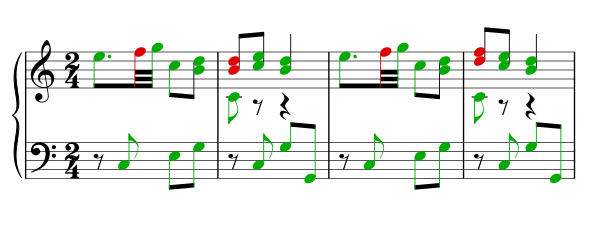

In [23]:
mozart_notes, mozart_chords = load_first_n_bars(
    EXAMPLE_DIR / "K330-3_notes.csv",
    EXAMPLE_DIR / "K330-3_chords.csv",
    n_bars=4,
)

result_mozart = percent_chord_df_match(mozart_notes, mozart_chords)
print(f"Chord match rate: {result_mozart['microaverage']:.0%}")
show_chord_matching(result_mozart["music_df"])

Chord match rate: 75%


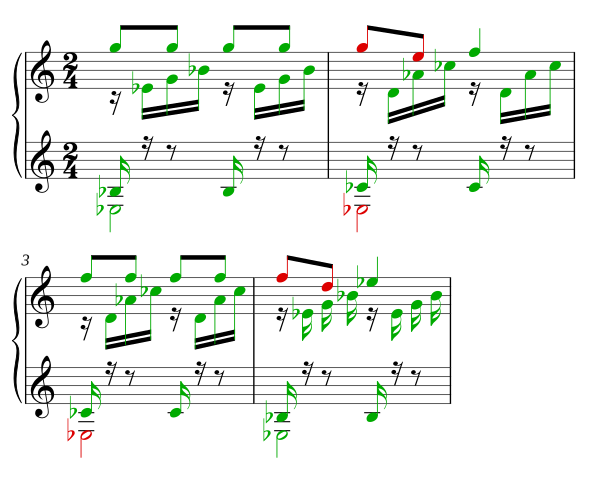

In [24]:
grieg_notes, grieg_chords = load_first_n_bars(
    EXAMPLE_DIR / "op12n01_notes.csv",
    EXAMPLE_DIR / "op12n01_chords.csv",
    n_bars=4,
)

result_grieg = percent_chord_df_match(grieg_notes, grieg_chords)
print(f"Chord match rate: {result_grieg['microaverage']:.0%}")
show_chord_matching(result_grieg["music_df"])